In [2]:
import pandas as pd
import plotnine as pn
# import tensorflow as tf
# import tensorflow_hub as hub

<Axes: title={'center': 'Loss over epochs'}, xlabel='Epoch', ylabel='Mean Squared Error'>

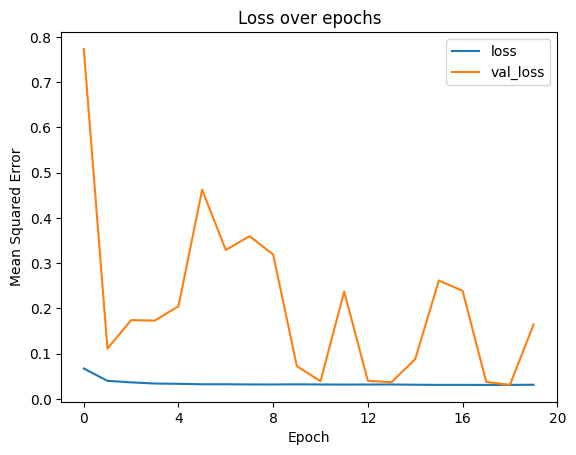

In [3]:
hist_full_2 = pd.read_csv(r"models\full_test_2_history.csv", index_col=0)
hist_full_2.plot(title = "Loss over epochs", ylabel="Mean Squared Error", xlabel="Epoch", xticks=list(range(21)[::4]))

### Run 5 Loss

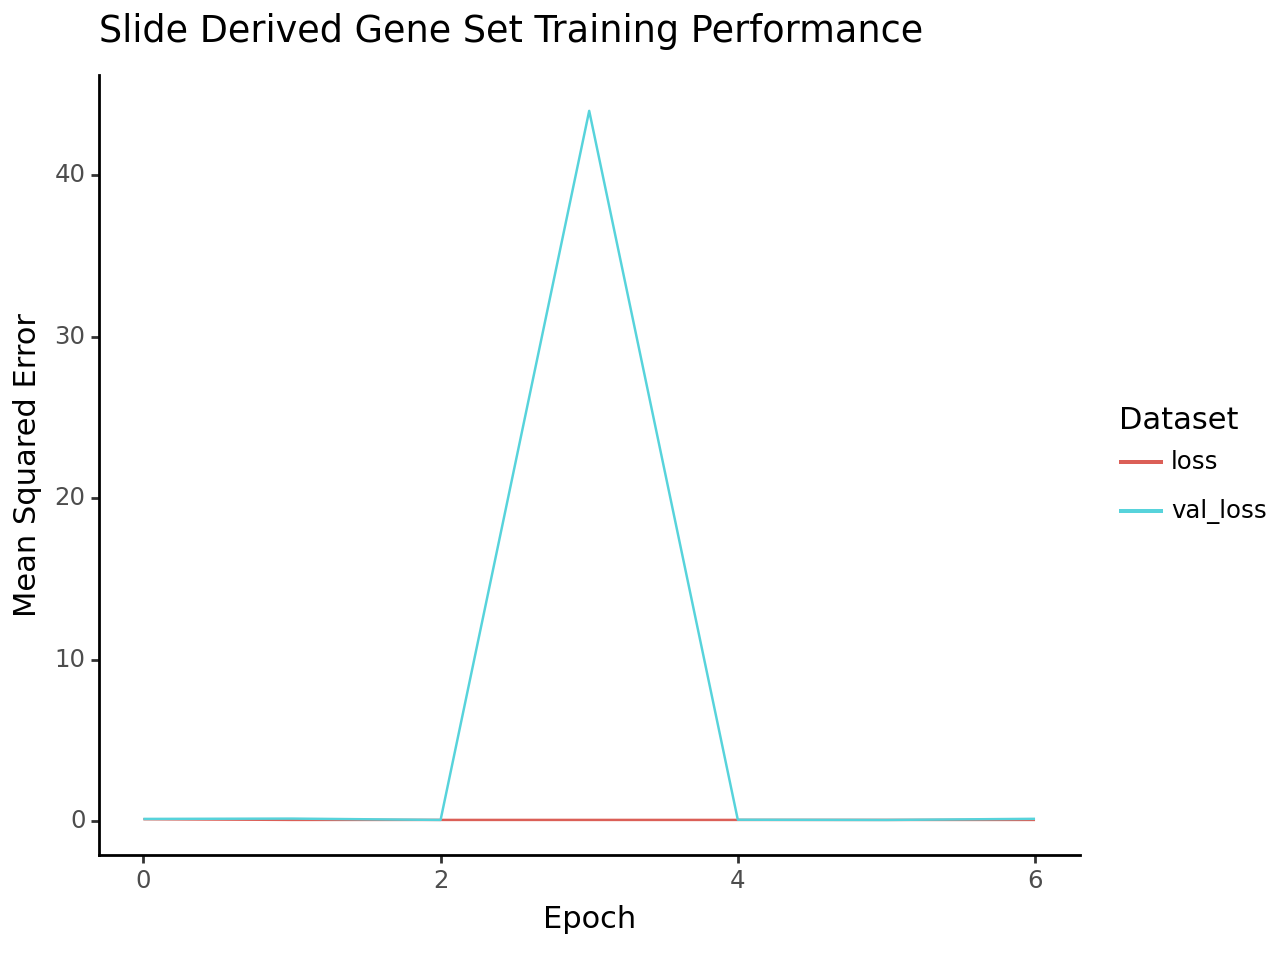

<Figure Size: (640 x 480)>

In [4]:
hist_updn = pd.read_csv("models/full_nn_5_updn_dropout_history.csv")
hist_updn.rename({hist_updn.columns[0]: 'Epoch'}, axis=1, inplace=True)
hist_updn_tidy = hist_updn.loc[:,['loss','val_loss', 'Epoch']].melt(
    id_vars=['Epoch'], var_name='Dataset', value_name='Mean Squared Error')
(
   pn.ggplot(hist_updn_tidy, pn.aes(x= 'Epoch', y = 'Mean Squared Error', color = 'Dataset')) +
   pn.geom_line() + 
   pn.ggtitle("Slide Derived Gene Set Training Performance") +
   pn.theme_classic()
)

### Run 6 Loss

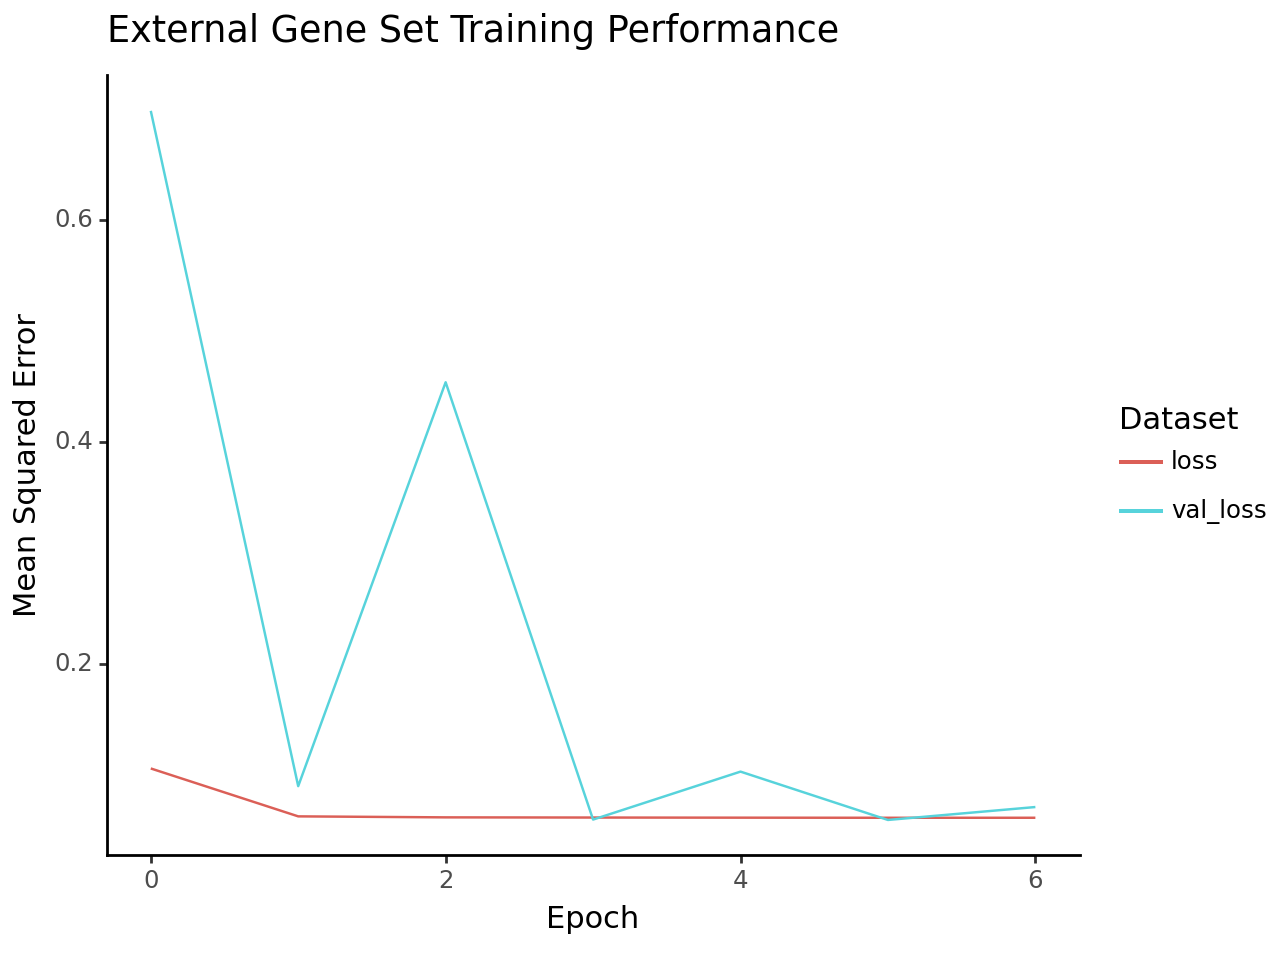

<Figure Size: (640 x 480)>

In [5]:
hist_external = pd.read_csv("models/full_nn_6_external_dropout_history.csv")
hist_external.rename({hist_external.columns[0]: 'Epoch'}, axis=1, inplace=True)
hist_external_tidy = hist_external.loc[:,['loss','val_loss', 'Epoch']].melt(
    id_vars=['Epoch'], var_name='Dataset', value_name='Mean Squared Error')
(
   pn.ggplot(hist_external_tidy, pn.aes(x= 'Epoch', y = 'Mean Squared Error', color = 'Dataset')) +
   pn.geom_line() +
   pn.ggtitle("External Gene Set Training Performance") +
   pn.theme_classic()
)


## Set up dataset for Prediction

### Get Images as Dataset

In [1]:
INPUT_IMAGES_DIR = "intermediate_data/patched_data/" 
DUMMY_IMAGE_FEATURES_DIR = "intermediate_data/batch_extracted_image_adatas"
ENRICHMENTS_DIR = "intermediate_data/enrichments_on_updn_de"

In [6]:
# Load in the dataset
# from model_architecture import dataset_from_spot_names
from linear_model_prediction import get_data_as_dfs
NONNORMALIZED = True
HOLDOUT_BIOPSIES = []
# Get enrichments and class info
_, updn_enrichments, spot_info = get_data_as_dfs(im_features_dir=DUMMY_IMAGE_FEATURES_DIR, enrichments_dir=ENRICHMENTS_DIR,
                                            nonnormalized=NONNORMALIZED,
                                            is_de=True,
                                            scale_by_means=True)
# Remove biopsies that have been designated as holdouts
for biop in HOLDOUT_BIOPSIES:
    updn_enrichments = updn_enrichments.filter(regex=f"^\w*-1_\d\d\D_(?!{biop})", axis=0)
# Get spot names for dataset making
spot_names = list(updn_enrichments.index)


# Train test split spots
# if NONNORMALIZED:
#     sd_nn_enrichments = updn_enrichments.std(axis=0)
#     mean_nn_enrichments = updn_enrichments.mean(axis=0)
#     updn_enrichments = updn_enrichments.sub(mean_nn_enrichments, axis=1).div(mean_nn_enrichments, axis = 1)

spot_suffixes = ["_" + x.split("_")[-1] for x in spot_names]


R^2 is 0.07162782028030623


In [6]:

# enrichments_df = enrichments

# from image_extracter import image_extracter
# helper_extracter = image_extracter()

# folder_w_barcode = [f"{INPUT_IMAGES_DIR}*{x.split('_')[-2][:-1]}_{x.split('_')[-2][-1]}*/patches/*{x.split('_')[0]}*" 
#                         for x in spot_names]
# image_set = helper_extracter.image_set_from_path(folder_w_barcode, 
#                                                 in_place = False, 
#                                                 name_append = spot_suffixes) # until spot naming is repaired
# images = image_set['images']

# enrichments_dataset = tf.data.Dataset.from_tensor_slices(enrichments_df.loc[spot_names, :])


GPU is available


In [8]:
# images.save("intermediate_data/predicted_enrichments/images_trained_on")

## Get Predicted Enrichment Scores

### Run 5 UP DN Model

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
from tensorflow_hub import KerasLayer

up_dn_model = load_model('models/full_nn_5_updn_dropout_nn_True.keras', 
                         custom_objects = {'KerasLayer': KerasLayer})
images = Dataset.load("intermediate_data/predicted_enrichments/images_trained_on")

array([[0.        , 0.31060463, 0.08386323, ..., 0.13315871, 0.32322744,
        0.        ],
       [0.        , 0.29651994, 0.07797956, ..., 0.12336984, 0.3129527 ,
        0.        ],
       [0.        , 0.30420667, 0.07832064, ..., 0.12728813, 0.31405732,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.23194022, 0.03654579, ..., 0.07340502, 0.24314478,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [11]:
up_dn_predicted_enrichments = up_dn_model.predict(images, use_multiprocessing=True)
up_dn_predicted_enrichments_df = pd.DataFrame(
    data = up_dn_predicted_enrichments,
    index = updn_enrichments.index,
    columns = updn_enrichments.columns
)
up_dn_predicted_enrichments_df.to_csv("intermediate_data/predicted_enrichments/predicted_updn/predicted_enrichments.csv")

Get enrichments to compare with

In [7]:
updn_enrichments.to_csv("intermediate_data/predicted_enrichments/predicted_updn_new/orig_enrichments.csv")
spot_info.to_csv("intermediate_data/predicted_enrichments/predicted_updn_new/orig_info.csv")

### Run 6 External Model

In [15]:
# Load in the dataset
# from model_architecture import dataset_from_spot_names
from linear_model_prediction import get_data_as_dfs
NONNORMALIZED = True
HOLDOUT_BIOPSIES = []
# Get enrichments and class info
_, external_enrichments, external_spot_info = get_data_as_dfs(im_features_dir=DUMMY_IMAGE_FEATURES_DIR, 
                                            enrichments_dir='intermediate_data/enrichments_on_external',
                                            nonnormalized=NONNORMALIZED, 
                                            is_de=False)
assert all(external_spot_info.index == spot_info.index)
# Remove biopsies that have been designated as holdouts
for biop in HOLDOUT_BIOPSIES:
    external_enrichments = external_enrichments.filter(regex=f"^\w*-1_\d\d\D_(?!{biop})", axis=0)
# Get spot names for dataset making
spot_names = list(external_enrichments.index)


# Train test split spots
if NONNORMALIZED:
    sd_nn_enrichments = external_enrichments.std(axis=0)
    mean_nn_enrichments = external_enrichments.mean(axis=0)
    external_enrichments = external_enrichments.sub(mean_nn_enrichments, axis=1).div(mean_nn_enrichments, axis = 1)

spot_suffixes = ["_" + x.split("_")[-1] for x in spot_names]


In [16]:
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
from tensorflow_hub import KerasLayer
# We load in the model
external_model = load_model('models/full_nn_6_external_dropout_nn_True.keras', 
                         custom_objects = {'KerasLayer': KerasLayer})
# We load in our images as a dataset, which SHOULD be the exact same
images = Dataset.load("intermediate_data/predicted_enrichments/images_trained_on")

In [18]:
external_predicted_enrichments = external_model.predict(images, use_multiprocessing=True)
external_predicted_enrichments_df = pd.DataFrame(
    data = external_predicted_enrichments,
    index = external_enrichments.index,
    columns = external_enrichments.columns
)
external_predicted_enrichments_df.to_csv("intermediate_data/predicted_enrichments/predicted_external/predicted_enrichments.csv")

In [19]:
external_enrichments.to_csv("intermediate_data/predicted_enrichments/predicted_external/orig_enrichments.csv")
spot_info.to_csv("intermediate_data/predicted_enrichments/predicted_external/orig_info.csv") # SHOULD be identical

## Run 9

In [ ]:
from linear_model_prediction import get_data_as_dfs
NONNORMALIZED = True
HOLDOUT_BIOPSIES = []
# Get enrichments and class info
_, external_enrichments, external_spot_info = get_data_as_dfs(im_features_dir=DUMMY_IMAGE_FEATURES_DIR, 
                                            enrichments_dir='intermediate_data/enrichments_on_external',
                                            nonnormalized=NONNORMALIZED, 
                                            is_de=False,
                                            scale_by_means=True)
assert all(external_spot_info.index == spot_info.index)
# Remove biopsies that have been designated as holdouts
for biop in HOLDOUT_BIOPSIES:
    external_enrichments = external_enrichments.filter(regex=f"^\w*-1_\d\d\D_(?!{biop})", axis=0)
# Get spot names for dataset making
spot_names = list(external_enrichments.index)


# Train test split spots
if NONNORMALIZED:
    sd_nn_enrichments = external_enrichments.std(axis=0)
    mean_nn_enrichments = external_enrichments.mean(axis=0)
    external_enrichments = external_enrichments.sub(mean_nn_enrichments, axis=1).div(mean_nn_enrichments, axis = 1)

spot_suffixes = ["_" + x.split("_")[-1] for x in spot_names]

## Run 8 20 epoch

In [1]:
# Load in the dataset
# from model_architecture import dataset_from_spot_names
from linear_model_prediction import get_data_as_dfs
NONNORMALIZED = True
HOLDOUT_BIOPSIES = []
DUMMY_IMAGE_FEATURES_DIR = "intermediate_data/batch_extracted_image_adatas"
# Get enrichments and class info
_, enrichments, spot_info = get_data_as_dfs(im_features_dir=DUMMY_IMAGE_FEATURES_DIR, 
                                            enrichments_dir="intermediate_data/enrichments_on_updn_de",
                                            nonnormalized=NONNORMALIZED, 
                                            is_de=True,
                                            scale_by_means=True)
# assert all(updn_new_spot_info.index == updn_new_enrichments.index)
# Remove biopsies that have been designated as holdouts
for biop in HOLDOUT_BIOPSIES:
    enrichments = enrichments.filter(regex=f"^\w*-1_\d\d\D_(?!{biop})", axis=0)
# Get spot names for dataset making
spot_names = list(enrichments.index)

spot_suffixes = ["_" + x.split("_")[-1] for x in spot_names]


# # Load in the dataset
# # from model_architecture import dataset_from_spot_names
# from linear_model_prediction import get_data_as_dfs
# NONNORMALIZED = True
# HOLDOUT_BIOPSIES = []
# # Get enrichments and class info
# _, updn_enrichments, spot_info = get_data_as_dfs(im_features_dir=DUMMY_IMAGE_FEATURES_DIR, enrichments_dir=ENRICHMENTS_DIR,
#                                             nonnormalized=NONNORMALIZED)
# # Remove biopsies that have been designated as holdouts
# for biop in HOLDOUT_BIOPSIES:
#     updn_enrichments = updn_enrichments.filter(regex=f"^\w*-1_\d\d\D_(?!{biop})", axis=0)
# # Get spot names for dataset making
# spot_names = list(updn_enrichments.index)


# # Train test split spots
# if NONNORMALIZED:
#     sd_nn_enrichments = updn_enrichments.std(axis=0)
#     mean_nn_enrichments = updn_enrichments.mean(axis=0)
#     updn_enrichments = updn_enrichments.sub(mean_nn_enrichments, axis=1).div(mean_nn_enrichments, axis = 1)


R^2 is 0.07162782028030623
                              S20T1_deg_set_dn  S20T1_deg_set_up  \
AAACAGCTTTCAGAAG-1_36B_S20T1          0.780051          0.780051   
AAACAGGGTCTATATT-1_36B_S20T1          0.921990          0.921990   
AAACCGGGTAGGTACC-1_36B_S20T1          1.338542          1.338542   
AAACCGTTCGTCCAGG-1_36B_S20T1          0.832926          0.832926   
AAACCTCATGAAGTTG-1_36B_S20T1          1.004371          1.004371   
...                                        ...               ...   
TTGTTCTAGATACGCT-1_86D_S8T3           0.946646          0.946646   
TTGTTGTGTGTCAAGA-1_86D_S8T3           0.865609          0.865609   
TTGTTTCACATCCAGG-1_86D_S8T3           0.868866          0.868866   
TTGTTTCATTAGTCTA-1_86D_S8T3           1.109060          1.109060   
TTGTTTCCATACAACT-1_86D_S8T3           1.006460          1.006460   

                              S20T2_deg_set_dn  S20T2_deg_set_up  \
AAACAGCTTTCAGAAG-1_36B_S20T1          0.793960          0.765331   
AAACAGGGTCTATATT-1_3

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.data import Dataset
from tensorflow_hub import KerasLayer
# We load in the model

updn_new_model = load_model("models/full_test_nn_8_dropout_nn_True.keras", 
                         custom_objects = {'KerasLayer': KerasLayer})
# We load in our images as a dataset, which SHOULD be the exact same
images = Dataset.load("intermediate_data/predicted_enrichments/images_trained_on")

In [3]:
import pandas as pd
updn_new_predicted_enrichments = updn_new_model.predict(images, use_multiprocessing=True)


31404/31404 [==============================] - 562s 18ms/step


In [5]:
updn_new_predicted_enrichments_df = pd.DataFrame(
    data = updn_new_predicted_enrichments,
    index = list(enrichments.index),
    columns = list(enrichments.columns)
)

# enrichments.shape
updn_new_predicted_enrichments_df.to_csv("intermediate_data/predicted_enrichments/predicted_updn_new/predicted_enrichments.csv")

In [ ]:
# updn_new_enrichments.to_csv("intermediate_data/predicted_enrichments/predicted_updn_new/orig_enrichments.csv")
# spot_info.to_csv("intermediate_data/predicted_enrichments/predicted_updn_new/orig_info.csv") # SHOULD be identical